In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, label_binarize
from scipy import sparse
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
import mca
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import log_loss, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

C:\Users\mingt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mingt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#stage 1 data
train_variants = pd.read_csv('C:\\Users\\mingt\\Downloads\\cancer\\training_variants')
test_variants = pd.read_csv('C:\\Users\\mingt\\Downloads\\cancer\\test_variants')
train_text = pd.read_csv('C:\\Users\\mingt\\Downloads\\cancer\\training_text', sep="\|\|", engine='python',
                         header=None, skiprows=1, names=["ID", "Text"])
test_text = pd.read_csv('C:\\Users\\mingt\\Downloads\\cancer\\test_text', sep="\|\|", engine='python',
                        header=None, skiprows=1, names=["ID", "Text"])

train_combined = pd.merge(train_variants, train_text, how='left', on='ID').fillna('Null')
test_combined = pd.merge(test_variants, test_text, how='left', on='ID').fillna('Null')

#stage 2 data
s1_solution = pd.read_csv('C:\\Users\\mingt\\Downloads\\\cancer\\stage1_solution_filtered.csv\\stage1_solution_filtered.csv')
#s2_private_solution = pd.read_csv('\cancer\stage_2_private_solution.csv\stage_2_private_solution.csv')
#s2_sample = pd.read_csv('\cancer\stage2_sample_submission.csv\stage2_sample_submission.csv')
#s2_test_text = pd.read_csv('\cancer\stage2_test_text.csv\stage2_test_text.csv', sep="\|\|", engine='python',
                        #header=None, skiprows=1, names=["ID", "Text"])
#s2_test_variants = pd.read_csv('\cancer\stage2_test_variants.csv\stage2_test_variants.csv')


# Data Exploration

In [ ]:
print("Out of " + str(len(train_combined)) + " training cases, there are:")
print(str(len(train_combined['Gene'].unique())) + " unique Genes")
print(str(len(train_combined['Variation'].unique())) + " unique Variations")
print(str(len(train_combined['Text'].unique())) + " unique Texts\n")

print("Out of " + str(len(test_combined)) + " testing cases, there are:")
print(str(len(test_combined['Gene'].unique())) + " unique Genes")
print(str(len(test_combined['Variation'].unique())) + " unique Variations")
print(str(len(test_combined['Text'].unique())) + " unique Texts")

print(train_combined.head(10))

# Exploratory Visualization

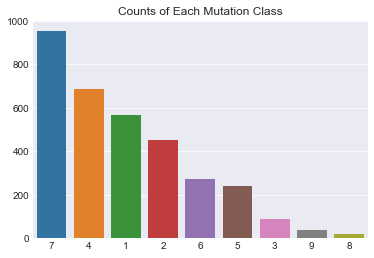

In [16]:
sns.set_style("darkgrid")

#Fig 1
class_counts = pd.value_counts(train_combined['Class'].values, sort=True)
classes = class_counts.index.values
sns.barplot(x=classes, y=class_counts, order= classes.tolist()).set_title('Counts of Each Mutation Class')

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
PIK3CA     56
CDKN2A     52
FGFR2      50
FLT3       49
TSC2       47
dtype: int64


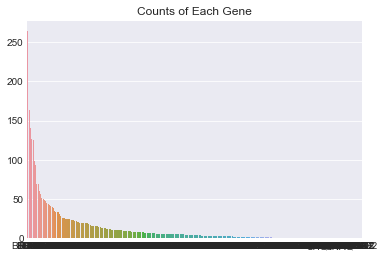

In [18]:
#Fig 2
gene_counts = pd.value_counts(train_combined['Gene'].values, sort=True)
genes = gene_counts.index.values
sns.barplot(x=genes, y=gene_counts, order=genes.tolist()).set_title('Counts of Each Gene')
print(gene_counts.head(15))

In [9]:
#Fig 3
variation_counts = pd.value_counts(train_combined['Variation'].values, sort=True)
print(variation_counts.head(15))
print(variation_counts.tail(15))

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
T58I                     3
Q61H                     3
Q61R                     3
E17K                     3
Q61L                     3
R841K                    2
G35R                     2
T73I                     2
Q22K                     2
dtype: int64
S502T                    1
G719D                    1
C24Y                     1
Y791F                    1
D84H                     1
C125S                    1
P577S                    1
I744_K745delinsKIPVAI    1
V561A                    1
V1398D                   1
S170R                    1
N2113S                   1
H701P                    1
E281K                    1
R1699Q                   1
dtype: int64


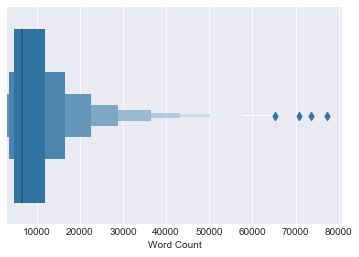

In [30]:
#Fig 5
word_count = pd.Series([len(str(x).split(' ')) for x in train_combined['Text']]).rename('Word Count')
sns.lvplot(word_count)

dict_keys(['using', 'control', 'samples', 'receptor', 'cells', 'exon', 'activity', 'high', 'used', 'human', 'egfr', 'resistance', 'previously', 'number', '10', '11', 'genes', 'mutation', 'missense', 'wt', 'tumor', 'performed', 'treatment', 'protein', 'loss', 'pathway', 'shown', 'fig', 'ras', 'mutations', 'identified', 'disease', 'phosphorylation', 'functional', 'growth', 'results', 'dna', 'compared', '12', 'expressing', 'mutants', 'structure', 'wild', 'sequence', '14', '20', 'p53', 'described', '15', 'showed', 'type', 'based', 'kinase', 'specific', 'cancer', 'pten', 'response', 'figure', 'amino', 'signaling', 'reported', 'alk', 'raf', 'analysis', 'assay', 'table', 'gene', 'variants', 'activation', 'patients', 'domain', 'studies', 'clinical', 'et', 'including', 'observed', 'brca1', 'data', 'lines', 'residues', 'associated', 'kit', 'different', 'levels', 'supplementary', 'al', 'âˆ', 'cell', 'binding', 'mutant', 'patient', 'study', 'tumors', 'expression', 'cases', 'function', 'site', 'mic

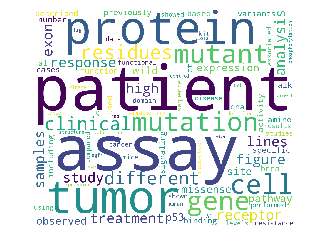

In [38]:
#Fig 6
count = TfidfVectorizer(stop_words ='english', analyzer='word', max_features=100)
count.fit_transform(train_combined['Text'])
vocab = count.vocabulary_.keys()

wc = WordCloud(background_color='white',
                          width=1200,
                          height=1000
                         ).generate(' '.join(vocab))

plt.imshow(wc)
plt.axis('off')
plt.show()

# Data Preprocessing

In [40]:
#Fig 9
sent = ("Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes" ,
        "CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed")
count = CountVectorizer(analyzer='word', stop_words='english')
count_matrix = count.fit_transform(sent)
print(count_matrix.todense())


[[0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1]
 [1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0]]


In [44]:
#Fig 10
tfidf = TfidfVectorizer(analyzer='word',stop_words='english')
matrix = tfidf.fit_transform(sent)
print(tfidf.idf_)

[ 1.40546511  1.40546511  1.40546511  1.          1.40546511  1.
  1.40546511  1.40546511  1.40546511  1.40546511  1.40546511  1.40546511
  1.40546511  1.40546511  1.40546511  1.40546511  1.40546511]


In [45]:
#Fig 11
print(matrix.todense())

[[ 0.          0.          0.          0.25136004  0.35327777  0.25136004
   0.35327777  0.35327777  0.          0.          0.35327777  0.
   0.35327777  0.35327777  0.          0.          0.35327777]
 [ 0.33310232  0.33310232  0.33310232  0.23700504  0.          0.23700504
   0.          0.          0.33310232  0.33310232  0.          0.33310232
   0.          0.          0.33310232  0.33310232  0.        ]]


In [50]:
#Fig 12
U, Sigma, VT = randomized_svd(matrix, n_components = 2, random_state=None)
print(U)
print(Sigma)
print(VT)
svd = TruncatedSVD(algorithm='randomized', n_components=2)
decomposed = svd.fit_transform(matrix)
print(decomposed)

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
[ 1.05789753  0.93853759]
[[ 0.22264813  0.22264813  0.22264813  0.32642695  0.23613355  0.32642695
   0.23613355  0.23613355  0.22264813  0.22264813  0.23613355  0.22264813
   0.23613355  0.23613355  0.22264813  0.22264813  0.23613355]
 [-0.25096374 -0.25096374 -0.25096374  0.01081525  0.2661642   0.01081525
   0.2661642   0.2661642  -0.25096374 -0.25096374  0.2661642  -0.25096374
   0.2661642   0.2661642  -0.25096374 -0.25096374  0.2661642 ]]
[[ 0.74804652  0.66364629]
 [ 0.74804652 -0.66364629]]


In [3]:
#Fig 13.
dummy_df = pd.get_dummies(train_combined[['Gene', 'Variation']])
#dummy_df.head(5)

     Eigenvalues  Expl_Var
200     0.594075  0.000661
201     0.545530  0.000607
202     0.528223  0.000588
203     0.503153  0.000560
204     0.476915  0.000530
205     0.296265  0.000330
206     0.249847  0.000278
207     0.249847  0.000278
208     0.249847  0.000278
209     0.249847  0.000278


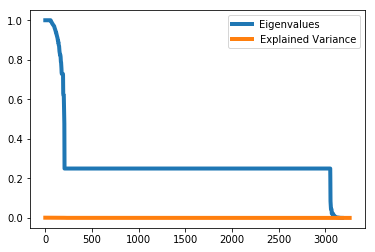

In [4]:
#Fig 14.
mca_obj = mca.MCA(dummy_df)

eigenvalues = pd.Series(mca_obj.L).rename('Eigenvalues')
expl_var= pd.Series(mca_obj.expl_var()).rename('Expl_Var')

eig_line, = plt.plot(eigenvalues, label='Eigenvalues', linewidth=4)
var_line = plt.plot(expl_var, label='Explained Variance', linewidth=4)
legend = plt.legend(handles=[eig_line,var_line[0]], loc=1)

eig_n_var = pd.concat([eigenvalues,expl_var], axis =1)
print(eig_n_var[200:210])

In [5]:
#Fig 15. 
tfidf_obj = TfidfVectorizer(analyzer='word',stop_words='english', max_df=0.9)
tfidf_matrix = tfidf_obj.fit_transform(train_combined['Text'])

components = 100
from sklearn.decomposition import TruncatedSVD
svd_obj = TruncatedSVD(algorithm='randomized', n_components=components)
decomposed = svd_obj.fit_transform(tfidf_matrix)
svd_df = pd.DataFrame(decomposed, columns= ['svd_component_' + str(x) for x in range(components)])

factors = 207
mca_df = pd.DataFrame(mca_obj.fs_r(N=factors), columns = ['mca_factor_' + str(x) for x in range(factors)])

features= pd.concat([mca_df, svd_df], axis=1)
features.head(5)

,mca_factor_0,mca_factor_1,mca_factor_2,mca_factor_3,mca_factor_4,mca_factor_5,mca_factor_6,mca_factor_7,mca_factor_8,mca_factor_9,...,svd_component_90,svd_component_91,svd_component_92,svd_component_93,svd_component_94,svd_component_95,svd_component_96,svd_component_97,svd_component_98,svd_component_99
0,-0.186777,3.050451e-12,-5.018459e-13,-6.349247e-13,-0.218798,-2.653868e-14,-3.372405e-13,-1.927983e-13,-7.685156e-14,1.631584e-13,...,-0.005631,0.013442,-0.016987,0.003697,-0.016460,0.002399,-0.001166,0.011756,0.006075,0.008721
1,-0.186777,2.657498e-12,-3.988737e-13,-5.215381e-13,-0.218798,-1.609083e-14,-2.599416e-13,-1.650799e-13,-8.378724e-14,1.701549e-13,...,-0.004730,0.002588,0.014317,-0.017940,-0.015963,0.009038,-0.008414,-0.005419,0.001500,0.001861
2,-0.186777,2.677962e-12,-4.088091e-13,-5.311867e-13,-0.218798,-2.503335e-14,-2.379709e-13,-1.614777e-13,-8.563084e-14,1.652091e-13,...,-0.004730,0.002588,0.014317,-0.017940,-0.015963,0.009038,-0.008414,-0.005419,0.001500,0.001861
3,-0.186777,2.662501e-12,-3.923163e-13,-5.113791e-13,-0.218798,-2.208263e-14,-2.691171e-13,-1.638718e-13,-8.758582e-14,1.753076e-13,...,-0.005666,0.002582,-0.001971,-0.014833,-0.019053,-0.002349,-0.004888,-0.010667,-0.025167,-0.006884
4,-0.186777,2.659405e-12,-3.900737e-13,-5.205750e-13,-0.218798,-1.394059e-14,-2.638222e-13,-1.678809e-13,-8.977859e-14,1.785555e-13,...,0.007982,-0.004979,-0.000430,0.017153,0.014919,0.003231,0.001316,0.007082,0.005824,0.006515


# Implementation

0.919233136634


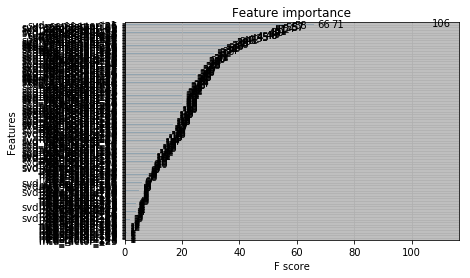

In [7]:
#Fig 16
lbe = LabelEncoder()
target = lbe.fit_transform(train_combined['Class'])

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.1, random_state=7)

xgbC = XGBClassifier()
xgbC.fit(X_train, y_train)

pred = xgbC.predict_proba(X_test)
print(log_loss(y_test, pred))

plot_importance(xgbC)

In [47]:
#Fig 17
def findStuff(x):
    n = np.array(x.split()).size
    i = x.split()[n - 1]
    if i.lower() == 'fusion':
        return 'Is_fusion'
    elif i.lower() == 'deletion':
        return 'Is_deletion'
    elif i.lower() == 'insertion':
        return 'Is_insertion'
    elif i.lower() == 'truncation':
        return 'Is_truncation'
    elif i.lower() == 'methylation':
        return 'Is_methylation'
    elif i.lower() == 'amplification':
        return 'Is_amplification'
    elif i.lower() == 'silencing':
        return 'Is_silencing'
    elif i.lower() == 'splicing':
        return 'Is_splicing'
    elif i.lower() == 'exon':
        return 'Is_exon'
    elif i.lower() == 'overexpression':
        return 'Is_overexpression'
    else:
        return 'None stated'
    
Is_feats = pd.get_dummies(train_combined['Variation'].apply(lambda x: findStuff(x)))


#text_len = pd.Series([len(x) for x in train_combined['Text']])
#word_count = pd.Series([len(str(x).split(' ')) for x in train_combined['Text']])

cosine = pd.DataFrame(mca_obj.cos_r(N=50), columns=['mca_cosines_' + str(x) for x in range(50)])


#new_features = pd.concat([features, text_len.rename('text_len'), word_count.rename('word_count'), fusion, cosine], axis = 1)

new_features = pd.concat([Is_feats, cosine], axis = 1)
features2 = pd.concat([features, Is_feats, cosine], axis = 1)
lbe = LabelEncoder()
target = lbe.fit_transform(train_combined['Class'])

print(new_features.head(5))
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target, 
                                                    test_size=0.1, random_state=7)


   Is_amplification  Is_deletion  Is_fusion  Is_insertion  Is_overexpression  \
0                 0            0          0             0                  0   
1                 0            0          0             0                  0   
2                 0            0          0             0                  0   
3                 0            0          0             0                  0   
4                 0            0          0             0                  0   

   Is_silencing  None stated  mca_cosines_0  mca_cosines_1  mca_cosines_2  \
0             0            1       0.000041   1.087661e-26   2.943787e-28   
1             0            1       0.000038   7.607029e-27   1.713720e-28   
2             0            1       0.000038   7.724633e-27   1.800156e-28   
3             0            1       0.000038   7.635699e-27   1.657837e-28   
4             0            1       0.000038   7.617949e-27   1.638938e-28   

        ...        mca_cosines_40  mca_cosines_41  mca_c

In [ ]:
xgbC2 = XGBClassifier()
xgbC2.fit(X_train2, y_train2)
pred = xgb2.predict_proba(X_test2)
print(log_loss(y_test2, pred))

In [70]:
#Fig 18

dmatrix = xgb.DMatrix(features2, target)

xgb_params_cv = dict(eta=0.1,
                  objective='multi:softprob',
                  num_class=9,
                  seed=7)

best = xgb.cv(params = xgb_params_cv, dtrain=dmatrix, num_boost_round=1000, metrics='mlogloss', early_stopping_rounds=100, verbose_eval=True)

best.tail(5)               

[0]	train-mlogloss:1.96636+0.00277611	test-mlogloss:2.01623+0.00389821
[1]	train-mlogloss:1.78136+0.00318584	test-mlogloss:1.87723+0.0048385
[2]	train-mlogloss:1.63123+0.0033835	test-mlogloss:1.76496+0.00413233
[3]	train-mlogloss:1.50678+0.00212764	test-mlogloss:1.67061+0.0047706
[4]	train-mlogloss:1.39802+0.00411204	test-mlogloss:1.59049+0.00425473
[5]	train-mlogloss:1.30397+0.00356348	test-mlogloss:1.52123+0.0051691
[6]	train-mlogloss:1.22128+0.00618487	test-mlogloss:1.46213+0.00604987
[7]	train-mlogloss:1.14617+0.00672643	test-mlogloss:1.40985+0.00659469
[8]	train-mlogloss:1.07719+0.00790759	test-mlogloss:1.36421+0.00722657
[9]	train-mlogloss:1.01609+0.00990015	test-mlogloss:1.32302+0.00779176
[10]	train-mlogloss:0.960955+0.00976124	test-mlogloss:1.28689+0.00883048
[11]	train-mlogloss:0.910078+0.0096441	test-mlogloss:1.2537+0.00850316
[12]	train-mlogloss:0.862409+0.0110997	test-mlogloss:1.22361+0.00912766
[13]	train-mlogloss:0.819432+0.0118186	test-mlogloss:1.19622+0.00974888
[14]	t

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
47,0.944925,0.014787,0.243016,0.002134
48,0.944536,0.014608,0.236455,0.002064
49,0.944194,0.014347,0.230594,0.001554
50,0.943802,0.014873,0.224461,0.000797
51,0.943477,0.015159,0.218675,0.000968


In [ ]:
"""
Step by step grid search parameter tuning for XGBoost, as explained by 
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python
"""

param_test1 = {
 'max_depth':[6,7,8],
 'min_child_weight':[4,5,6]}

 
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[8,9,10]}

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]}


param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]}


param_test5 = {
 'reg_alpha':[1e-5, 1e-4, 1e-3]}


param_test6 = {
 'reg_alpha':[0.1, 0.2, 0.3]}

param_test6dot5 = {
 'reg_alpha':[1e-7, 1e-8, 1e-9]}

param_test7 = {
   'learning_rate':[0.11, 0.12, 0.13]}

param_test8 = {
   'learning_rate':[0.13""" 0.14, 0.15"""]}

#Optimal parameters for this tree
grid = GridSearchCV(estimator=XGBClassifier(learning_rate=0.13,
                  n_estimators=55,
                  max_depth=5,
                  min_child_weight=8,
                  gamma=0,
                  subsample=0.9,
                  colsample_bytree=0.6,
                  objective='multi:softprob',
                  nthread=4,
                  scale_pos_weight=1,
                  reg_alpha=0.0001,
                  seed=7), 
                     param_grid = param_test8, scoring='log_loss',n_jobs=4, cv=5)

grid.fit(X_train2,y_train2)

In [5]:
#Complete pipeline to tune data preprocessing and estimator if enough time
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X): 
        return X[self.key]
    
class DummyMCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_factors):
        self.n_factors = n_factors

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        mca_obj = mca.MCA(pd.get_dummies(X), TOL=1e-2)
        factors = pd.DataFrame(mca_obj.fs_r(N=self.n_factors), columns= ['mca_factor' + str(x) for x in range(self.n_factors)])
        cosines = pd.DataFrame(mca_obj.fs_r(N=self.n_factors), columns= ['mca_cosine' + str(x) for x in range(self.n_factors)])
        mca_df = pd.concat([factors, cosines], axis =1)
        return mca_df
    
    

pipeline = Pipeline(steps=[
    ('union', FeatureUnion(
        transformer_list=[
            ('transform_text',
             Pipeline([
                 ('select_column', ColumnSelector(key='Text')),
                 ('tfidf', TfidfVectorizer(analyzer='word', max_df=0.9, stop_words='english', norm='l2',
                                           sublinear_tf=True, use_idf=True)),
                 ('svd', TruncatedSVD(algorithm='randomized', n_components=100)),
             ])
             ),
            ('transform_categories',
             Pipeline([
                 ('select_columns', ColumnSelector(key=['Gene', 'Variation'])),
                 ('dummy_mca', DummyMCA(n_factors=207)),
             ])
             ),
        ],
    )),
    ('xgb', XGBClassifier(learning_rate=0.13,
                  n_estimators=55,
                  max_depth=5,
                  min_child_weight=8,
                  gamma=0,
                  subsample=0.9,
                  colsample_bytree=0.6,
                  objective='multi:softprob',
                  nthread=4,
                  scale_pos_weight=1,
                  reg_alpha=0.0001,
                  seed=7)),
])

params = dict(
    union__transform_text__tfidf__max_df=[1, 0.9],
    union__transform_text__tfidf__ngram_range=[(1, 1), (1, 2)],
    union__transform_text__svd_text__n_components=[100, 200, 300],
    union__transform_text__svd_text__n_iter=[5, 7],
    union__transform_categories__dummy_mca__n_factors=[50, 100],
    xgb__learning_rate=[0.1, 0.05, 0.01],
    xgb__max_depth=[2,3,5],
    xgb_min_child_weight=[6,7,8])

#grid = GridSearchCV(pipeline, param_grid=params)
#grid.fit(X_train2, y_train2)

# Model Evaluation

In [32]:
get_ids = s1_solution['ID'].values
cases = test_combined.iloc[get_ids]
cases_features = cases[['Gene', 'Variation', 'Text']]

a = s1_solution.drop(['ID'], axis=1)
a.columns= [1,2,3,4,5,6,7,8,9]
cases_target = lbe.fit_transform(a.idxmax(1))


train_features = train_combined[['Gene', 'Variation', 'Text']]
lbe = LabelEncoder()
target3 = lbe.fit_transform(train_combined['Class'])

pipe1 = pipeline.fit(train_features, target3)
unseen_pred = pipe1.predict_proba(cases_features)
result = log_loss(cases_target, unseen_pred)
print(result)

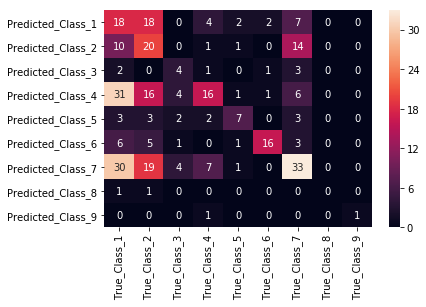

In [37]:
#Fig 18
lbe = LabelEncoder()
target3 = lbe.fit_transform(train_combined['Class'])

features3 = train_combined[['Gene', 'Variation', 'Text']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(features3, target3, 
                                                    test_size=0.1, random_state=0)

pipe2 = pipeline.fit(X_train3, y_train3)
pred3 = pipeline.predict(X_test3)

conf_matrix = confusion_matrix(y_test3, pred3)

xlabels = ['True_Class_' + str(x) for x in range(1,10)]
ylabels = ['Predicted_Class_' + str(x) for x in range(1,10)]
sns.set
sns.heatmap(conf_matrix, annot=True, xticklabels=xlabels, yticklabels=ylabels)

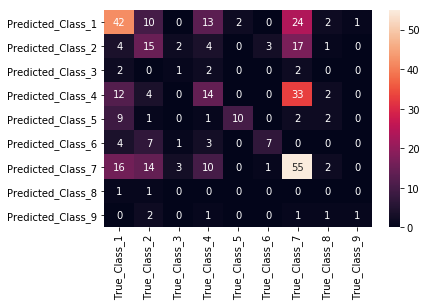

In [35]:
#Confusion matrix with stage 1 solution as unseen data
unseen_pred2 = pipeline.predict(cases_features)
unseen_conf_matrix = confusion_matrix(cases_target, unseen_pred2)

sns.heatmap(unseen_conf_matrix, annot=True, xticklabels=xlabels, yticklabels=ylabels)

In [59]:
#Adding ROC AUC chart to model evaluation 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

target3 = label_binarize(train_combined['Class'], classes=[1,2,3,4,5,6,7,8,9])
n_classes = 9


X_train3, X_test3, y_train3, y_test3 = train_test_split(features2, target3, 
                                                    test_size=0.1, random_state=0)

classifier = OneVsRestClassifier(GradientBoostingClassifier(learning_rate=0.13,
                  n_estimators=55,
                  max_depth=5,
                  min_samples_split=8,
                  #gamma=0,
                  subsample=0.9
                  ))

y_score = classifier.fit(X_train3, y_train3).predict_proba(X_test3)



fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test3[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test3.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


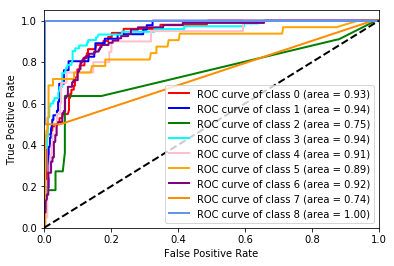

In [63]:
#Fig 19
colors = list(['red', 'blue', 'green', 'aqua','pink','orange', 'purple', 'yellow', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Conclusion

In [ ]:
vec2 = TfidfVectorizer(ngram_range=(5,12), max_features=200
                       vec2.fit_transform(train_text['Text'][:300])
vec2.vocabulary_